In [1]:
IMG_URL = "https://api.time.com/wp-content/uploads/2019/04/katiebouman.jpg"

In [8]:
import torch
import numpy as np
import urllib
from PIL import Image
from torchvision import transforms

model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

# Download an example image from the pytorch website
url, filename = (IMG_URL, "original.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

input_image = Image.open(filename)

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

postprocess = transforms.Compose([
    transforms.Normalize(mean=-mean/std, std=1/std),
    transforms.ToPILImage(),
])

if torch.cuda.is_available():
    model.to('cuda')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [3]:
def remove_background(img, model):
    input_batch = preprocess(img)[None, ...]

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
        output_predictions = torch.nn.functional.softmax(output, dim=0)

    img.putalpha(255)
    result_np = np.array(img)
    result_np[..., 3] = (1-output_predictions[0].cpu().numpy())*255
    
    return Image.fromarray(result_np.astype('uint8'))

In [12]:
import time
img = input_image.copy()

start_time = time.time()
result = remove_background(img, model)
print('time elapsed: {}'.format(time.time()-start_time))

time elapsed: 0.8021562099456787


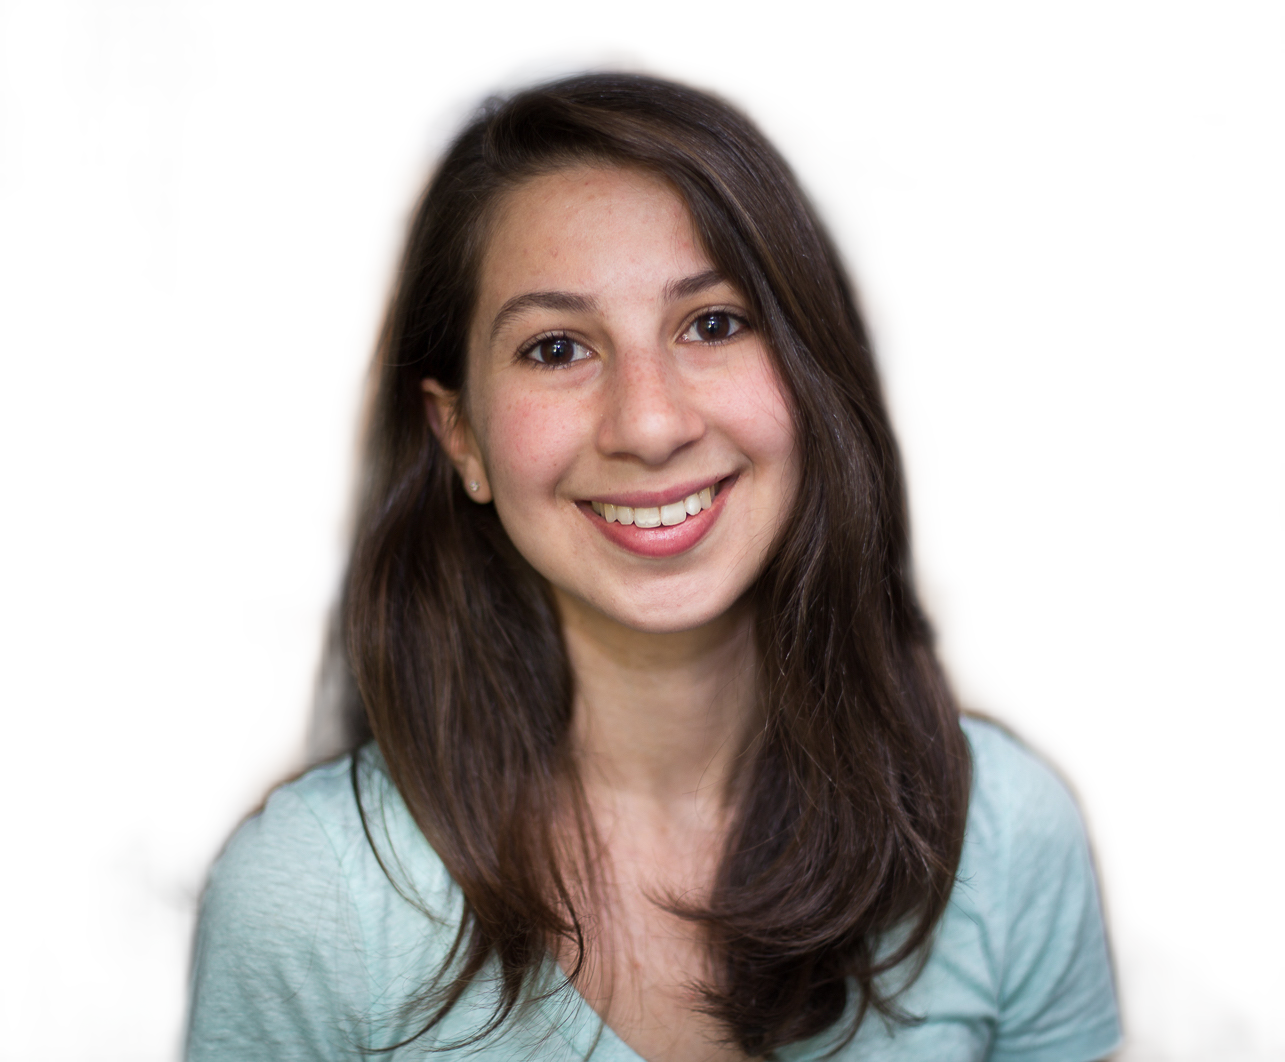

In [13]:
# show result
result